# Example for analysis of NanoAOD samples

In this example we don't need any pre-processing of NanoAOD samples and can still use several tools of the tW_scattering repository.

- Get the proper normalization for samples
- Categorize different samples into process categories
- Use coffea processors for the map-reduce step
- Make "nice" histograms


In [1]:
%load_ext autoreload
%autoreload 2

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

from processor.charge_flip_calc import charge_flip_calc
from Tools.config_helpers import loadConfig
from klepto.archives import dir_archive
import time

year = 2018

In [3]:
from processor.default_accumulators import desired_output, add_processes_to_output

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_fnal
from Tools.nano_mapping import make_fileset, nano_mapping

from processor.meta_processor import get_sample_meta

overwrite = False
local = True

# load the config and the cache
cfg = loadConfig()

cacheName = 'charge_flip_calc'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

# get a python dictionary of all NanoAOD samples
# The samples definitions can be found in data/samples.yaml
samples = get_samples(year)

# make a fileset, taking the definitions in Tools/nano_mapping.py
fileset = make_fileset(['DY', 'top', 'TTZ'], year, redirector=redirector_ucsd, small=False) 

# in order for cutflows to work we need to add every process to the output accumulator
add_processes_to_output(fileset, desired_output)

histograms = sorted(list(desired_output.keys()))

#meta = get_sample_meta(fileset, samples)

chunksize = 25000

if local:

    exe_args = {
        'workers': 16,
        'function_args': {'flatten': False},
        "schema": NanoAODSchema,
        "skipbadfiles": True,
    }
    exe = processor.futures_executor

else:
    from Tools.helpers import get_scheduler_address
    from dask.distributed import Client, progress
    
    scheduler_address = get_scheduler_address()
    c = Client(scheduler_address)
    
    def unique(filename):
        file, ext = os.path.splitext(filename)
        counter = 0
        while os.path.exists(filename):
            counter += 1
            filename = file + str(counter) + ext
        return filename

    tstart = time.time()
    
    from dask.distributed import performance_report
    fname = unique("dask/dask-report_chunksize=" + str(chunksize/1000) + "K.html")
    
    exe_args = {
        'client': c,
        'function_args': {'flatten': False},
        "schema": NanoAODSchema,
        "skipbadfiles": True,
        'savemetrics': True
    }
    exe = processor.dask_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")
    #with performance_report(filename=fname):
    output = processor.run_uproot_job(
        fileset,
        "Events",
        charge_flip_calc(year=year, variations=[], accumulator=desired_output),
        exe,
        exe_args,
        chunksize=chunksize,
        )

    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

samples_2018.yaml


In [4]:
output['totalEvents']['all']/1e6

187.989937

Full fileset is 180M events, and that's basically just DY and ttbar.

In [5]:
# import the plotting libararies: matplotlib and mplhep
from Tools.nano_mapping import make_fileset, nano_mapping
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import numpy as np

# load the functions to make a nice plot from the output histograms
# and the scale_and_merge function that scales the individual histograms
# to match the physical cross section

from plots.helpers import makePlot, scale_and_merge

# define a few axes that we can use to rebin our output histograms

N_bins         = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red     = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins        = hist.Bin('pt', r'$p_{T}\ (GeV)$', np.array([15, 40, 60, 80, 100, 200, 300]))
pt_fine_bins   = hist.Bin('pt', r'$p_{T}\ (GeV)$', 300, 0, 300)
eta_bins       = hist.Bin('eta', r'$\eta $', np.array([0, 0.8, 1.479, 2.5]))
phi_bins       = hist.Bin('phi', r'$\phi $', 16, -3.2, 3.2)


# define nicer labels and colors

nano_mappings = nano_mapping(year)

my_labels = {
    nano_mappings['TTW'][0]: 'ttW',
    nano_mappings['TTZ'][0]: 'ttZ',
    nano_mappings['DY'][0]: 'DY',
    nano_mappings['top'][0]: 't/tt+jets',
}

my_colors = {
    nano_mappings['TTW'][0]: '#8AC926',
    nano_mappings['TTZ'][0]: '#FFCA3A',
    nano_mappings['DY'][0]: '#6A4C93',
    nano_mappings['top'][0]: '#1982C4',
}



# 2D Histograms

In [6]:
from yahist import Hist1D, Hist2D
import numpy as np

In [7]:
tmp1 = output['mva_id2'].copy()

tmp3 = output['mva_id'].copy()
#tmp3 = tmp3.rebin('eta', eta_bins)
#tmp3 = tmp3.rebin('pt', pt_bins)


tmp4 = output['isolation'].copy()
#tmp4 = tmp4.rebin('eta', eta_bins)
#tmp4 = tmp4.rebin('pt', pt_bins)

h1 = Hist2D.from_bincounts(
    tmp1.sum('dataset').values()[()].T,
    (tmp1.axis('mva_id').edges(), tmp1.axis('pt').edges()),
)

h3 = Hist2D.from_bincounts(
    tmp3.sum('dataset').values()[()].T,
    (tmp3.axis('mva_id').edges(), tmp3.axis('eta').edges()),
)


h4 = Hist2D.from_bincounts(
    tmp4.sum('dataset').values()[()].T,
    (tmp4.axis('isolation1').edges(), tmp4.axis('isolation2').edges()),
)

Text(0, 1, '$p_{T}\\ (GeV)$')

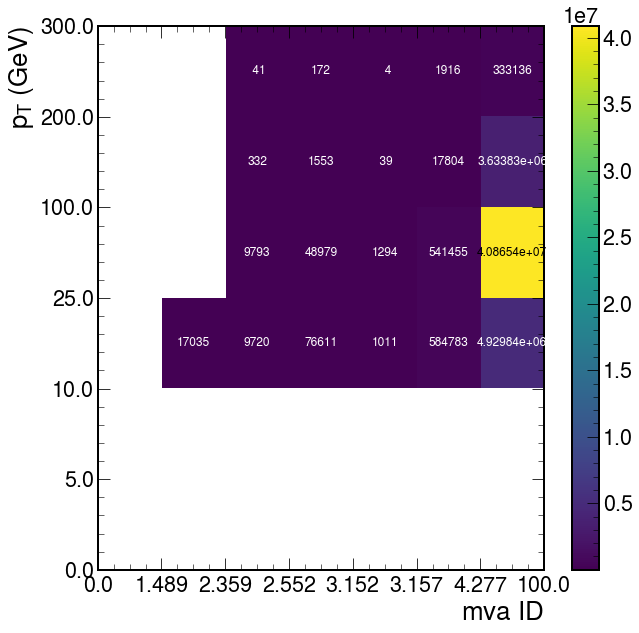

In [8]:
plt.style.use(hep.style.CMS)
fig, ax  = plt.subplots(1, 1,figsize=(10,10) )
h1.plot(show_counts=True, equidistant='xy')
ax.set_xlabel(r'$mva\ ID$')
ax.set_ylabel(r'$p_{T}\ (GeV)$')

Text(0, 1, '$etaSC$')

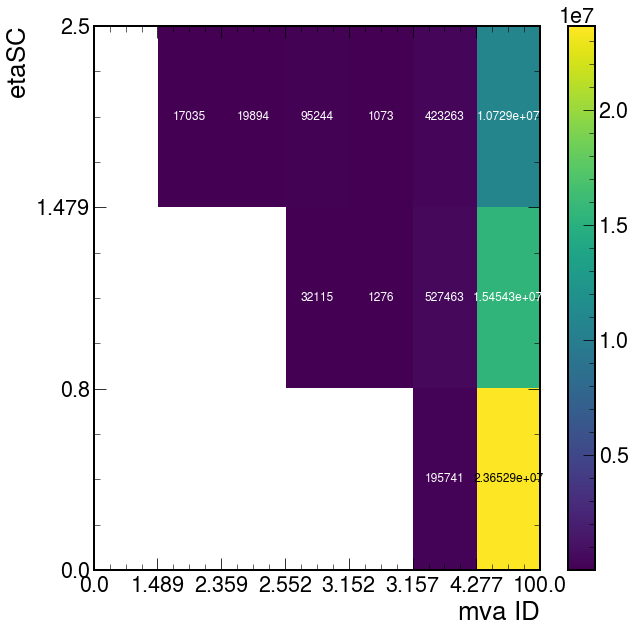

In [11]:
plt.style.use(hep.style.CMS)
fig, ax  = plt.subplots(1, 1,figsize=(10,10) )
h3.plot(show_counts=True, equidistant='xy')
ax.set_xlabel(r'$mva\ ID$')
ax.set_ylabel(r'$etaSC$')

Text(0, 1, '$jetPtRelv2$')

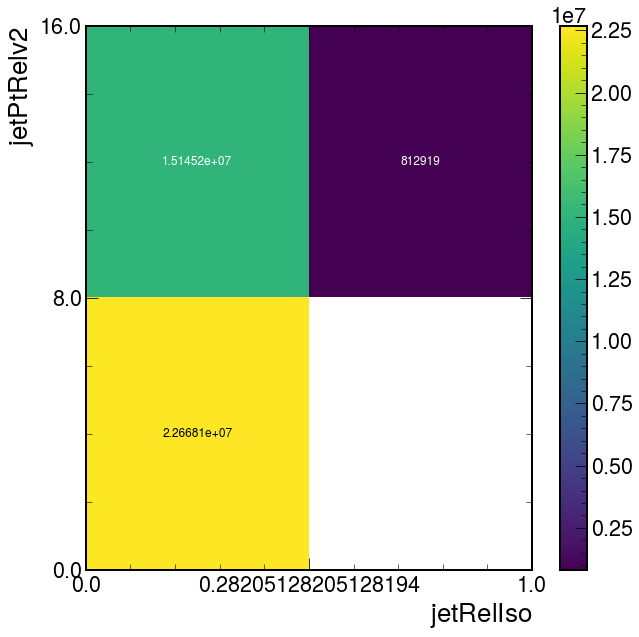

In [12]:
plt.style.use(hep.style.CMS)
fig, ax  = plt.subplots(1, 1,figsize=(10,10) )
h4.plot(show_counts=True, equidistant='xy')
ax.set_xlabel(r'$jetRelIso$')
ax.set_ylabel(r'$jetPtRelv2$')